# Training a convolutional neural network with Caffe

We want to train a classifier on the MNIST dataset, which is a publically available dataset of handwritten digits such as the ones below:

![image](./mnistdigits.gif)

We will use a very basic convolutional network architecture called LeNet, which looks something like this:

![image](./lenet5.png)

Since the network is pretty small and the classification task isn't too demanding, it won't take too long time to train to decent precision from scratch.

In our case we've preloaded the dataset, but it can be loaded with these scripts available in the default caffe installation:

```
data/mnist/get_mnist.sh
examples/mnist/create/mnist.sh
```

In [2]:
caffe_root = '/home/ubuntu/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

from pylab import *
%matplotlib inline

/usr/lib/python2.7/dist-packages/pkg_resources.py:1031: UserWarning: /home/ubuntu/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [25]:
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    #n.dropout1 = L.Dropout(n.relu1, dropout_ratio=0.5)
    #n.ip2 = L.InnerProduct(n.dropout1, num_output=10, weight_filler=dict(type='xavier'))
    n.ip2 = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    
with open(caffe_root + 'examples/mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet(caffe_root + 'examples/mnist/mnist_train_lmdb', 64)))
    
with open(caffe_root + 'examples/mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet(caffe_root + 'examples/mnist/mnist_test_lmdb', 100)))

In [4]:
# write out model definition from file
!cat ./lenet_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  include {
    phase: TRAIN
  }
  data_param {
    source: "/home/ubuntu/caffe/examples/mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  include {
    phase: TEST
  }
  data_param {
    source: "/home/ubuntu/caffe/examples/mnist/mnist_test_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_outpu

In [5]:
# write out solver parameters from file
!cat ./lenet_solver.prototxt

# The train/test net protocol buffer definition
net: "/home/ubuntu/notebooks/lenet_train.prototxt"
#train_net: "/home/ubuntu/caffe/examples/mnist/lenet_auto_train.prototxt"
#test_net: "/home/ubuntu/caffe/examples/mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "/home/ubuntu/caffe/examples/mnist/lenet"


Learning rate is most important hyperparameter of training model.

![learning rates](./learningrates.jpeg)

Other hyperparameters are learning rate policy ("step","?","inverse"), weight decay (regularization), etc.
Best option to use grid search or similar, but this may take *very* long time.

Very common to set weight decay in this range : 0.0005, and momentum at 0.9, so these are reasonable guesses for a network, but may need tuning.

Can run training from command line:
```
build/tools/caffe train -solver /home/ubuntu/notebook/lenet_solver.prototxt -gpu 0
```
We will do it in python to be able to print loss and accuracy plots.

In [6]:
# set up the solver
caffe.set_mode_gpu()
solver = caffe.SGDSolver('./lenet_solver.prototxt')

In [7]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 2.59 s, sys: 1.34 s, total: 3.93 s
Wall time: 2.9 s


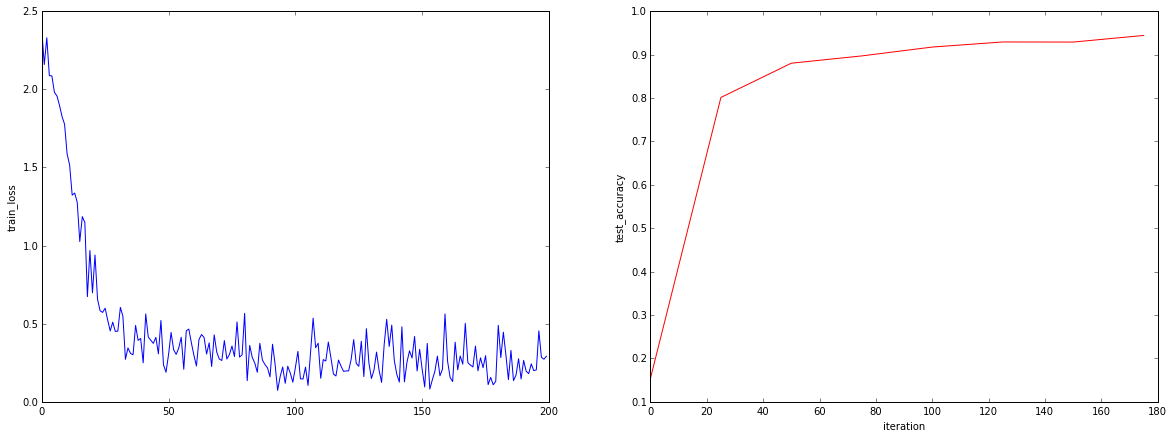

In [8]:
# plot train loss and testset accuracy
rcParams['figure.figsize'] = (20, 7)
pl1 = subplot(1,2,1)
pl1.plot(arange(niter), train_loss)
pl1.set_ylabel('train_loss')
pl2 = subplot(1,2,2)
pl2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
pl2.set_ylabel('test_accuracy')
pl2.set_xlabel('iteration')

In [10]:
# 0.001
print test_acc

[ 0.1542  0.8013  0.8802  0.897   0.9174  0.9291  0.9289  0.9441]


In [15]:
# 0.01 # common default learning rate
# see e.g. Practical Recommendations for Gradient-Based Training of Deep Architectures (Bengio 2012)
print test_acc

[ 0.1107  0.7882  0.8805  0.8971  0.9099  0.9202  0.9139  0.9236]


In [19]:
# 0.1
print test_acc

[ 0.2585  0.2078  0.098   0.098   0.098   0.098   0.098   0.098 ]


In [7]:
# 0.01, no momentum
print test_acc

[ 0.1265  0.642   0.7549  0.8103  0.8431  0.8598  0.8666  0.8748]


In [19]:
# 0.01, with 0.5 dropout on first fully connected
print test_acc

[ 0.0892  0.8049  0.8684  0.8962  0.9169  0.9211  0.9344  0.9353]


In [ ]:
# alternative training with adadelta

In [ ]:
# alternatively run everything with script
# caffe train model="" tra...